## Work
1. 請改變 reduce_lr 的 patience 和 factor 並比較不同設定下，對訓練/驗證集的影響
2. 請將 optimizer 換成 Adam、RMSprop 搭配 reduce_lr 並比較訓練結果

In [1]:
import os
import keras

# Disable GPU
#os.environ["CUDA_VISIBLE_DEVICES"] = ""
import tensorflow as tf
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.333)
sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.layers import BatchNormalization

def build_mlp(input_shape, output_units=10, num_neurons=[256, 256, 256]):
    """Code Here
    建立你的神經網路
    """
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
LEARNING_RATE = 1e-3
EPOCHS = 25 # IF you feel too run to finish, try to make it smaller
BATCH_SIZE = 1024 

In [7]:
# 載入 Callbacks
from keras.callbacks import ReduceLROnPlateau

optimizer_set = [keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=0.95),
                 keras.optimizers.Adam(lr=LEARNING_RATE),
                 keras.optimizers.RMSprop(lr=LEARNING_RATE)]

"""Code Here
建立實驗的比較組合
"""
reduce_lr_factor = [0.3, 0.5, 0.7, 0.9]
redice_lr_patient = [3, 5, 7, 9]

In [8]:
import itertools
results = {}
for i, (optim, reduce_factor, reduce_patient) in enumerate(itertools.product(optimizer_set, reduce_lr_factor, redice_lr_patient)):
    keras.backend.clear_session() # 把舊的 Graph 清掉
    print("Numbers of exp: %i, reduce_factor: %.2f, reduce_patient: %i" % (i, reduce_factor, reduce_patient))
    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optim)
    
    """Code Here
    設定 reduce learning rate 的 callback function
    """
    reduce_lr = ReduceLROnPlateau(factor=reduce_factor, 
                                  min_lr=1e-12, 
                                  monitor='val_loss', 
                                  patience=reduce_patient, 
                                  verbose=1)
    
    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True,
              callbacks=[reduce_lr]
             )

    # Collect results
    exp_name_tag = ("exp-%s" % (i))
    results[exp_name_tag] = {'train-loss': model.history.history["loss"],
                             'valid-loss': model.history.history["val_loss"],
                             'train-acc': model.history.history["acc"],
                             'valid-acc': model.history.history["val_acc"]}

Numbers of exp: 0, reduce_factor: 0.30, reduce_patient: 3




Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               786688    
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               65792     
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 256)               65792     
_______________________________________________________________

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 2s 48us/step - loss: 2.4994 - acc: 0.2016 - val_loss: 2.2703 - val_acc: 0.2643
Epoch 2/25
50000/50000 [==============================] - 2s 36us/step - loss: 2.0009 - acc: 0.3179 - val_loss: 2.0420 - val_acc: 0.3163
Epoch 3/25
50000/50000 [==============================] - 2s 36us/step - loss: 1.8479 - acc: 0.3608 - val_loss: 1.9095 - val_acc: 0.3507
Epoch 4/25
50000/50000 [==============================] - 2s 36us/step - loss: 1.7651 - acc: 0.3866 - val_loss: 1.8202 - val_acc: 0.3733
Epoch 5/25
50000/50000 [==============================] - 2s 36us/step - loss: 1.7078 - acc: 0.4035 - val_loss: 1.7780 - val_acc: 0.3881
Epoch 6/25
50000/50000 [==============================] - 2s 36us/step - loss: 1.6630 - acc: 0.4196 - val_loss: 1.7400 - val_acc: 0.3963
Epoch 7/25
50000/50000 [==============================] - 2s 36us/step - loss: 1.6277 - acc: 0.4308 - val_loss: 1.7149 - val_acc

50000/50000 [==============================] - 2s 36us/step - loss: 1.3385 - acc: 0.5351 - val_loss: 1.5313 - val_acc: 0.4620
Epoch 25/25
50000/50000 [==============================] - 2s 36us/step - loss: 1.3272 - acc: 0.5396 - val_loss: 1.5299 - val_acc: 0.4650
Numbers of exp: 3, reduce_factor: 0.30, reduce_patient: 9
Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               786688    
_________________________________________________________________
batch_normalization_10 (Batc (None, 256)               1024      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               65792     
_________________________________________________________________
b

50000/50000 [==============================] - 2s 36us/step - loss: 1.5327 - acc: 0.4662 - val_loss: 1.6393 - val_acc: 0.4238
Epoch 12/25
50000/50000 [==============================] - 2s 36us/step - loss: 1.5137 - acc: 0.4720 - val_loss: 1.6306 - val_acc: 0.4247
Epoch 13/25
50000/50000 [==============================] - 2s 39us/step - loss: 1.4965 - acc: 0.4791 - val_loss: 1.6203 - val_acc: 0.4306
Epoch 14/25
50000/50000 [==============================] - 2s 36us/step - loss: 1.4781 - acc: 0.4851 - val_loss: 1.6035 - val_acc: 0.4367
Epoch 15/25
50000/50000 [==============================] - 2s 36us/step - loss: 1.4627 - acc: 0.4909 - val_loss: 1.5949 - val_acc: 0.4367
Epoch 16/25
50000/50000 [==============================] - 2s 36us/step - loss: 1.4486 - acc: 0.4946 - val_loss: 1.5891 - val_acc: 0.4412
Epoch 17/25
50000/50000 [==============================] - 2s 36us/step - loss: 1.4341 - acc: 0.4996 - val_loss: 1.5790 - val_acc: 0.4432
Epoch 18/25
50000/50000 [=====================

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 3s 55us/step - loss: 2.4887 - acc: 0.2067 - val_loss: 2.2773 - val_acc: 0.2623
Epoch 2/25
50000/50000 [==============================] - 2s 36us/step - loss: 2.0093 - acc: 0.3175 - val_loss: 2.0221 - val_acc: 0.3321
Epoch 3/25
50000/50000 [==============================] - 2s 36us/step - loss: 1.8598 - acc: 0.3589 - val_loss: 1.9108 - val_acc: 0.3576
Epoch 4/25
50000/50000 [==============================] - 2s 36us/step - loss: 1.7735 - acc: 0.3845 - val_loss: 1.8318 - val_acc: 0.3719
Epoch 5/25
50000/50000 [==============================] - 2s 36us/step - loss: 1.7135 - acc: 0.4041 - val_loss: 1.7760 - val_acc: 0.3865
Epoch 6/25
50000/50000 [==============================] - 2s 36us/step - loss: 1.6676 - acc: 0.4175 - val_loss: 1.7312 - val_acc: 0.4004
Epoch 7/25
50000/50000 [==============================] - 2s 36us/step - loss: 1.6286 - acc: 0.4316 - val_loss: 1.7101 - val_acc

Epoch 24/25
50000/50000 [==============================] - 2s 37us/step - loss: 1.3407 - acc: 0.5341 - val_loss: 1.5354 - val_acc: 0.4636
Epoch 25/25
50000/50000 [==============================] - 2s 36us/step - loss: 1.3299 - acc: 0.5372 - val_loss: 1.5332 - val_acc: 0.4638
Numbers of exp: 8, reduce_factor: 0.70, reduce_patient: 3
Model: "model_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               786688    
_________________________________________________________________
batch_normalization_25 (Batc (None, 256)               1024      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               65792     
_______________________________________________________

50000/50000 [==============================] - 2s 36us/step - loss: 1.5243 - acc: 0.4673 - val_loss: 1.6239 - val_acc: 0.4325
Epoch 12/25
50000/50000 [==============================] - 2s 38us/step - loss: 1.5051 - acc: 0.4734 - val_loss: 1.6099 - val_acc: 0.4406
Epoch 13/25
50000/50000 [==============================] - 2s 38us/step - loss: 1.4879 - acc: 0.4798 - val_loss: 1.6025 - val_acc: 0.4450
Epoch 14/25
50000/50000 [==============================] - 2s 40us/step - loss: 1.4705 - acc: 0.4877 - val_loss: 1.5850 - val_acc: 0.4492
Epoch 15/25
50000/50000 [==============================] - 2s 37us/step - loss: 1.4545 - acc: 0.4939 - val_loss: 1.5759 - val_acc: 0.4520
Epoch 16/25
50000/50000 [==============================] - 2s 37us/step - loss: 1.4398 - acc: 0.4983 - val_loss: 1.5655 - val_acc: 0.4540
Epoch 17/25
50000/50000 [==============================] - 2s 37us/step - loss: 1.4251 - acc: 0.5037 - val_loss: 1.5614 - val_acc: 0.4548
Epoch 18/25
50000/50000 [=====================

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 3s 65us/step - loss: 2.4766 - acc: 0.2098 - val_loss: 2.3805 - val_acc: 0.2580 0s - loss: 2.5790 - acc: 
Epoch 2/25
50000/50000 [==============================] - 2s 37us/step - loss: 1.9770 - acc: 0.3258 - val_loss: 2.0164 - val_acc: 0.3206
Epoch 3/25
50000/50000 [==============================] - 2s 37us/step - loss: 1.8308 - acc: 0.3662 - val_loss: 1.8991 - val_acc: 0.3550
Epoch 4/25
50000/50000 [==============================] - 2s 37us/step - loss: 1.7534 - acc: 0.3895 - val_loss: 1.8298 - val_acc: 0.3661
Epoch 5/25
50000/50000 [==============================] - 2s 36us/step - loss: 1.6988 - acc: 0.4070 - val_loss: 1.7780 - val_acc: 0.3893
Epoch 6/25
50000/50000 [==============================] - 2s 37us/step - loss: 1.6560 - acc: 0.4207 - val_loss: 1.7478 - val_acc: 0.3927
Epoch 7/25
50000/50000 [==============================] - 2s 37us/step - loss: 1.6210 - acc: 0.4323 - 

Epoch 24/25
50000/50000 [==============================] - 2s 36us/step - loss: 1.3459 - acc: 0.5302 - val_loss: 1.5393 - val_acc: 0.4646
Epoch 25/25
50000/50000 [==============================] - 2s 36us/step - loss: 1.3347 - acc: 0.5354 - val_loss: 1.5329 - val_acc: 0.4641
Numbers of exp: 13, reduce_factor: 0.90, reduce_patient: 5
Model: "model_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_14 (InputLayer)        (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               786688    
_________________________________________________________________
batch_normalization_40 (Batc (None, 256)               1024      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               65792     
_____________________________________________________

50000/50000 [==============================] - 2s 36us/step - loss: 1.5483 - acc: 0.4603 - val_loss: 1.6512 - val_acc: 0.4201: 1.5530 - acc: 0.
Epoch 11/25
50000/50000 [==============================] - 2s 39us/step - loss: 1.5272 - acc: 0.4675 - val_loss: 1.6419 - val_acc: 0.4275
Epoch 12/25
50000/50000 [==============================] - 2s 39us/step - loss: 1.5082 - acc: 0.4749 - val_loss: 1.6244 - val_acc: 0.4345
Epoch 13/25
50000/50000 [==============================] - 2s 39us/step - loss: 1.4907 - acc: 0.4787 - val_loss: 1.6178 - val_acc: 0.4328
Epoch 14/25
50000/50000 [==============================] - 2s 44us/step - loss: 1.4735 - acc: 0.4842 - val_loss: 1.6024 - val_acc: 0.4446
Epoch 15/25
50000/50000 [==============================] - 2s 39us/step - loss: 1.4581 - acc: 0.4907 - val_loss: 1.5965 - val_acc: 0.4454
Epoch 16/25
50000/50000 [==============================] - 2s 37us/step - loss: 1.4425 - acc: 0.4961 - val_loss: 1.5826 - val_acc: 0.4451s - loss: 1.4368 
Epoch 17/25

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 4s 88us/step - loss: 1.7810 - acc: 0.3817 - val_loss: 1.8746 - val_acc: 0.3729
Epoch 2/25
50000/50000 [==============================] - 2s 39us/step - loss: 1.4868 - acc: 0.4735 - val_loss: 1.8355 - val_acc: 0.3823
Epoch 3/25
50000/50000 [==============================] - 2s 38us/step - loss: 1.3702 - acc: 0.5135 - val_loss: 1.7574 - val_acc: 0.3945
Epoch 4/25
50000/50000 [==============================] - 2s 38us/step - loss: 1.2842 - acc: 0.5469 - val_loss: 1.8554 - val_acc: 0.3630
Epoch 5/25
50000/50000 [==============================] - 2s 38us/step - loss: 1.2215 - acc: 0.5670 - val_loss: 1.6952 - val_acc: 0.4064
Epoch 6/25
50000/50000 [==============================] - 2s 38us/step - loss: 1.1569 - acc: 0.5922 - val_loss: 2.1088 - val_acc: 0.3309
Epoch 7/25
50000/50000 [==============================] - 2s 38us/step - loss: 1.1029 - acc: 0.6129 - val_loss: 1.7505 - val_acc

50000/50000 [==============================] - 2s 38us/step - loss: 1.1502 - acc: 0.6060 - val_loss: 1.4759 - val_acc: 0.4839
Epoch 23/25
50000/50000 [==============================] - 2s 38us/step - loss: 1.1375 - acc: 0.6113 - val_loss: 1.4701 - val_acc: 0.4886
Epoch 24/25
50000/50000 [==============================] - 2s 38us/step - loss: 1.1261 - acc: 0.6151 - val_loss: 1.4604 - val_acc: 0.4887
Epoch 25/25
50000/50000 [==============================] - 2s 38us/step - loss: 1.1150 - acc: 0.6195 - val_loss: 1.4555 - val_acc: 0.4923
Numbers of exp: 18, reduce_factor: 0.30, reduce_patient: 7
Model: "model_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_19 (InputLayer)        (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               786688    
_____________________________________________________

50000/50000 [==============================] - 2s 38us/step - loss: 1.3306 - acc: 0.5385 - val_loss: 1.5238 - val_acc: 0.4642
Epoch 10/25
50000/50000 [==============================] - 2s 38us/step - loss: 1.3114 - acc: 0.5458 - val_loss: 1.5054 - val_acc: 0.4731
Epoch 11/25
50000/50000 [==============================] - 2s 38us/step - loss: 1.2901 - acc: 0.5525 - val_loss: 1.5023 - val_acc: 0.4742
Epoch 12/25
50000/50000 [==============================] - 2s 38us/step - loss: 1.2719 - acc: 0.5602 - val_loss: 1.4961 - val_acc: 0.4718
Epoch 13/25
50000/50000 [==============================] - 2s 38us/step - loss: 1.2547 - acc: 0.5669 - val_loss: 1.4766 - val_acc: 0.4780
Epoch 14/25
50000/50000 [==============================] - 2s 38us/step - loss: 1.2377 - acc: 0.5730 - val_loss: 1.4869 - val_acc: 0.4732
Epoch 15/25
50000/50000 [==============================] - 2s 38us/step - loss: 1.2226 - acc: 0.5800 - val_loss: 1.4691 - val_acc: 0.4765
Epoch 16/25
50000/50000 [=====================

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 5s 91us/step - loss: 2.0286 - acc: 0.3197 - val_loss: 1.9182 - val_acc: 0.3563
Epoch 2/25
50000/50000 [==============================] - 2s 38us/step - loss: 1.6510 - acc: 0.4269 - val_loss: 1.7615 - val_acc: 0.3899
Epoch 3/25
50000/50000 [==============================] - 2s 38us/step - loss: 1.5523 - acc: 0.4553 - val_loss: 1.6396 - val_acc: 0.4281
Epoch 4/25
50000/50000 [==============================] - 2s 38us/step - loss: 1.4907 - acc: 0.4790 - val_loss: 1.6222 - val_acc: 0.4359
Epoch 5/25
50000/50000 [==============================] - 2s 38us/step - loss: 1.4483 - acc: 0.4962 - val_loss: 1.5962 - val_acc: 0.4362
Epoch 6/25
50000/50000 [==============================] - 2s 38us/step - loss: 1.4111 - acc: 0.5074 - val_loss: 1.5679 - val_acc: 0.4435
Epoch 7/25
50000/50000 [==============================] - 2s 38us/step - loss: 1.3805 - acc: 0.5204 - val_loss: 1.5412 - val_acc

50000/50000 [==============================] - 2s 38us/step - loss: 1.1019 - acc: 0.6258 - val_loss: 1.4480 - val_acc: 0.4972
Epoch 25/25
50000/50000 [==============================] - 2s 38us/step - loss: 1.0900 - acc: 0.6292 - val_loss: 1.4495 - val_acc: 0.4956
Numbers of exp: 23, reduce_factor: 0.50, reduce_patient: 9
Model: "model_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_24 (InputLayer)        (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               786688    
_________________________________________________________________
batch_normalization_70 (Batc (None, 256)               1024      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               65792     
_________________________________________________________________

50000/50000 [==============================] - 2s 38us/step - loss: 1.2898 - acc: 0.5530 - val_loss: 1.4934 - val_acc: 0.4773
Epoch 12/25
50000/50000 [==============================] - 2s 39us/step - loss: 1.2696 - acc: 0.5615 - val_loss: 1.4861 - val_acc: 0.4751
Epoch 13/25
50000/50000 [==============================] - 2s 39us/step - loss: 1.2536 - acc: 0.5665 - val_loss: 1.4757 - val_acc: 0.4787
Epoch 14/25
50000/50000 [==============================] - 2s 41us/step - loss: 1.2359 - acc: 0.5724 - val_loss: 1.4741 - val_acc: 0.4840
Epoch 15/25
50000/50000 [==============================] - 2s 39us/step - loss: 1.2199 - acc: 0.5799 - val_loss: 1.4689 - val_acc: 0.4804
Epoch 16/25
50000/50000 [==============================] - 2s 39us/step - loss: 1.2043 - acc: 0.5864 - val_loss: 1.4609 - val_acc: 0.4848
Epoch 17/25
50000/50000 [==============================] - 2s 39us/step - loss: 1.1906 - acc: 0.5915 - val_loss: 1.4587 - val_acc: 0.4893
Epoch 18/25
50000/50000 [=====================

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 5s 108us/step - loss: 2.0440 - acc: 0.3124 - val_loss: 2.0576 - val_acc: 0.3209
Epoch 2/25
50000/50000 [==============================] - 2s 38us/step - loss: 1.6669 - acc: 0.4152 - val_loss: 1.7920 - val_acc: 0.3727
Epoch 3/25
50000/50000 [==============================] - 2s 38us/step - loss: 1.5684 - acc: 0.4515 - val_loss: 1.6730 - val_acc: 0.4107
Epoch 4/25
50000/50000 [==============================] - 2s 41us/step - loss: 1.5072 - acc: 0.4721 - val_loss: 1.6103 - val_acc: 0.4368
Epoch 5/25
50000/50000 [==============================] - 2s 39us/step - loss: 1.4615 - acc: 0.4878 - val_loss: 1.5767 - val_acc: 0.4478
Epoch 6/25
50000/50000 [==============================] - 2s 38us/step - loss: 1.4223 - acc: 0.5027 - val_loss: 1.5697 - val_acc: 0.4520
Epoch 7/25
50000/50000 [==============================] - 2s 38us/step - loss: 1.3925 - acc: 0.5145 - val_loss: 1.5483 - val_ac

50000/50000 [==============================] - 2s 38us/step - loss: 1.1040 - acc: 0.6248 - val_loss: 1.4372 - val_acc: 0.4889
Epoch 25/25
50000/50000 [==============================] - 2s 38us/step - loss: 1.0937 - acc: 0.6290 - val_loss: 1.4411 - val_acc: 0.4875
Numbers of exp: 28, reduce_factor: 0.90, reduce_patient: 3
Model: "model_29"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_29 (InputLayer)        (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               786688    
_________________________________________________________________
batch_normalization_85 (Batc (None, 256)               1024      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               65792     
_________________________________________________________________

50000/50000 [==============================] - 2s 38us/step - loss: 1.2952 - acc: 0.5520 - val_loss: 1.5120 - val_acc: 0.4676
Epoch 12/25
50000/50000 [==============================] - 2s 38us/step - loss: 1.2776 - acc: 0.5573 - val_loss: 1.4866 - val_acc: 0.4781
Epoch 13/25
50000/50000 [==============================] - 2s 38us/step - loss: 1.2603 - acc: 0.5636 - val_loss: 1.4833 - val_acc: 0.4785
Epoch 14/25
50000/50000 [==============================] - 2s 38us/step - loss: 1.2435 - acc: 0.5712 - val_loss: 1.4744 - val_acc: 0.4825
Epoch 15/25
50000/50000 [==============================] - 2s 38us/step - loss: 1.2292 - acc: 0.5772 - val_loss: 1.4747 - val_acc: 0.4851
Epoch 16/25
50000/50000 [==============================] - 2s 42us/step - loss: 1.2132 - acc: 0.5825 - val_loss: 1.4809 - val_acc: 0.4768
Epoch 17/25
50000/50000 [==============================] - 2s 38us/step - loss: 1.1998 - acc: 0.5869 - val_loss: 1.4572 - val_acc: 0.4899
Epoch 18/25
50000/50000 [=====================

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 6s 120us/step - loss: 2.0239 - acc: 0.3216 - val_loss: 1.9308 - val_acc: 0.3335
Epoch 2/25
50000/50000 [==============================] - 2s 38us/step - loss: 1.6472 - acc: 0.4215 - val_loss: 1.7378 - val_acc: 0.4020
Epoch 3/25
50000/50000 [==============================] - 2s 39us/step - loss: 1.5491 - acc: 0.4547 - val_loss: 1.6339 - val_acc: 0.4214
Epoch 4/25
50000/50000 [==============================] - 2s 39us/step - loss: 1.4903 - acc: 0.4778 - val_loss: 1.5961 - val_acc: 0.4426
Epoch 5/25
50000/50000 [==============================] - 2s 38us/step - loss: 1.4449 - acc: 0.4936 - val_loss: 1.5960 - val_acc: 0.4433
Epoch 6/25
50000/50000 [==============================] - 2s 38us/step - loss: 1.4101 - acc: 0.5054 - val_loss: 1.5827 - val_acc: 0.4473
Epoch 7/25
50000/50000 [==============================] - 2s 38us/step - loss: 1.3776 - acc: 0.5191 - val_loss: 1.5334 - val_ac

50000/50000 [==============================] - 2s 38us/step - loss: 0.6260 - acc: 0.8000 - val_loss: 1.3477 - val_acc: 0.5517
Epoch 23/25
50000/50000 [==============================] - 2s 38us/step - loss: 0.6228 - acc: 0.7992 - val_loss: 1.3524 - val_acc: 0.5509

Epoch 00023: ReduceLROnPlateau reducing learning rate to 8.100000013655517e-06.
Epoch 24/25
50000/50000 [==============================] - 2s 38us/step - loss: 0.6166 - acc: 0.8045 - val_loss: 1.3546 - val_acc: 0.5488
Epoch 25/25
50000/50000 [==============================] - 2s 38us/step - loss: 0.6162 - acc: 0.8031 - val_loss: 1.3559 - val_acc: 0.5476
Numbers of exp: 33, reduce_factor: 0.30, reduce_patient: 5
Model: "model_34"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_34 (InputLayer)        (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 25

Epoch 9/25
50000/50000 [==============================] - 2s 38us/step - loss: 1.8431 - acc: 0.3616 - val_loss: 1.8862 - val_acc: 0.3550
Epoch 10/25
50000/50000 [==============================] - 2s 38us/step - loss: 1.8099 - acc: 0.3711 - val_loss: 1.8620 - val_acc: 0.3641
Epoch 11/25
50000/50000 [==============================] - 2s 38us/step - loss: 1.7824 - acc: 0.3801 - val_loss: 1.8336 - val_acc: 0.3696
Epoch 12/25
50000/50000 [==============================] - 2s 38us/step - loss: 1.7563 - acc: 0.3878 - val_loss: 1.8148 - val_acc: 0.3753
Epoch 13/25
50000/50000 [==============================] - 2s 38us/step - loss: 1.7341 - acc: 0.3944 - val_loss: 1.7927 - val_acc: 0.3799
Epoch 14/25
50000/50000 [==============================] - 2s 38us/step - loss: 1.7128 - acc: 0.4007 - val_loss: 1.7781 - val_acc: 0.3850
Epoch 15/25
50000/50000 [==============================] - 2s 38us/step - loss: 1.6938 - acc: 0.4071 - val_loss: 1.7583 - val_acc: 0.3926
Epoch 16/25
50000/50000 [==========

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 7s 134us/step - loss: 2.7068 - acc: 0.1614 - val_loss: 2.5478 - val_acc: 0.2045
Epoch 2/25
50000/50000 [==============================] - 2s 38us/step - loss: 2.3496 - acc: 0.2286 - val_loss: 2.3134 - val_acc: 0.2439
Epoch 3/25
50000/50000 [==============================] - 2s 38us/step - loss: 2.1824 - acc: 0.2675 - val_loss: 2.1778 - val_acc: 0.2730
Epoch 4/25
50000/50000 [==============================] - 2s 38us/step - loss: 2.0767 - acc: 0.2966 - val_loss: 2.0908 - val_acc: 0.2976
Epoch 5/25
50000/50000 [==============================] - 2s 38us/step - loss: 2.0010 - acc: 0.3171 - val_loss: 2.0314 - val_acc: 0.3117
Epoch 6/25
50000/50000 [==============================] - 2s 38us/step - loss: 1.9415 - acc: 0.3338 - val_loss: 1.9809 - val_acc: 0.3264
Epoch 7/25
50000/50000 [==============================] - 2s 38us/step - loss: 1.8944 - acc: 0.3454 - val_loss: 1.9400 - val_ac

Epoch 24/25
50000/50000 [==============================] - 2s 38us/step - loss: 1.5561 - acc: 0.4545 - val_loss: 1.6679 - val_acc: 0.4154
Epoch 25/25
50000/50000 [==============================] - 2s 38us/step - loss: 1.5465 - acc: 0.4577 - val_loss: 1.6634 - val_acc: 0.4177
Numbers of exp: 38, reduce_factor: 0.50, reduce_patient: 7
Model: "model_39"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_39 (InputLayer)        (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               786688    
_________________________________________________________________
batch_normalization_115 (Bat (None, 256)               1024      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               65792     
_____________________________________________________

50000/50000 [==============================] - 2s 38us/step - loss: 1.7654 - acc: 0.3918 - val_loss: 1.8264 - val_acc: 0.3733
Epoch 12/25
50000/50000 [==============================] - 2s 38us/step - loss: 1.7420 - acc: 0.3999 - val_loss: 1.8069 - val_acc: 0.3781
Epoch 13/25
50000/50000 [==============================] - 2s 38us/step - loss: 1.7185 - acc: 0.4068 - val_loss: 1.7837 - val_acc: 0.3806
Epoch 14/25
50000/50000 [==============================] - 2s 38us/step - loss: 1.6983 - acc: 0.4137 - val_loss: 1.7692 - val_acc: 0.3839
Epoch 15/25
50000/50000 [==============================] - 2s 38us/step - loss: 1.6794 - acc: 0.4192 - val_loss: 1.7547 - val_acc: 0.3931
Epoch 16/25
50000/50000 [==============================] - 2s 38us/step - loss: 1.6620 - acc: 0.4246 - val_loss: 1.7415 - val_acc: 0.3908
Epoch 17/25
50000/50000 [==============================] - 2s 38us/step - loss: 1.6459 - acc: 0.4290 - val_loss: 1.7256 - val_acc: 0.3989
Epoch 18/25
50000/50000 [=====================

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 7s 149us/step - loss: 2.6020 - acc: 0.1747 - val_loss: 2.5362 - val_acc: 0.2169
Epoch 2/25
50000/50000 [==============================] - 2s 38us/step - loss: 2.3074 - acc: 0.2381 - val_loss: 2.3317 - val_acc: 0.2541
Epoch 3/25
50000/50000 [==============================] - 2s 38us/step - loss: 2.1588 - acc: 0.2758 - val_loss: 2.1919 - val_acc: 0.2794
Epoch 4/25
50000/50000 [==============================] - 2s 38us/step - loss: 2.0619 - acc: 0.3019 - val_loss: 2.1047 - val_acc: 0.2990
Epoch 5/25
50000/50000 [==============================] - 2s 38us/step - loss: 1.9903 - acc: 0.3204 - val_loss: 2.0257 - val_acc: 0.3142
Epoch 6/25
50000/50000 [==============================] - 2s 38us/step - loss: 1.9336 - acc: 0.3353 - val_loss: 1.9717 - val_acc: 0.3312
Epoch 7/25
50000/50000 [==============================] - 2s 39us/step - loss: 1.8867 - acc: 0.3498 - val_loss: 1.9276 - val_ac

50000/50000 [==============================] - 2s 38us/step - loss: 1.5544 - acc: 0.4562 - val_loss: 1.6719 - val_acc: 0.4129
Epoch 25/25
50000/50000 [==============================] - 2s 38us/step - loss: 1.5446 - acc: 0.4606 - val_loss: 1.6659 - val_acc: 0.4156
Numbers of exp: 43, reduce_factor: 0.70, reduce_patient: 9
Model: "model_44"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_44 (InputLayer)        (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               786688    
_________________________________________________________________
batch_normalization_130 (Bat (None, 256)               1024      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               65792     
_________________________________________________________________

50000/50000 [==============================] - 2s 38us/step - loss: 1.7686 - acc: 0.3854 - val_loss: 1.8269 - val_acc: 0.3738
Epoch 12/25
50000/50000 [==============================] - 2s 38us/step - loss: 1.7451 - acc: 0.3927 - val_loss: 1.8059 - val_acc: 0.3816
Epoch 13/25
50000/50000 [==============================] - 2s 38us/step - loss: 1.7217 - acc: 0.3991 - val_loss: 1.7898 - val_acc: 0.3835
Epoch 14/25
50000/50000 [==============================] - 2s 38us/step - loss: 1.7007 - acc: 0.4072 - val_loss: 1.7720 - val_acc: 0.3900
Epoch 15/25
50000/50000 [==============================] - 2s 38us/step - loss: 1.6820 - acc: 0.4134 - val_loss: 1.7565 - val_acc: 0.3934
Epoch 16/25
50000/50000 [==============================] - 2s 38us/step - loss: 1.6645 - acc: 0.4186 - val_loss: 1.7451 - val_acc: 0.3935
Epoch 17/25
50000/50000 [==============================] - 2s 38us/step - loss: 1.6480 - acc: 0.4261 - val_loss: 1.7329 - val_acc: 0.3988
Epoch 18/25
50000/50000 [=====================

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 8s 165us/step - loss: 2.6926 - acc: 0.1543 - val_loss: 2.5469 - val_acc: 0.1972
Epoch 2/25
50000/50000 [==============================] - 2s 38us/step - loss: 2.3682 - acc: 0.2217 - val_loss: 2.3367 - val_acc: 0.2328
Epoch 3/25
50000/50000 [==============================] - 2s 38us/step - loss: 2.2010 - acc: 0.2604 - val_loss: 2.1944 - val_acc: 0.2648
Epoch 4/25
50000/50000 [==============================] - 2s 38us/step - loss: 2.0922 - acc: 0.2869 - val_loss: 2.1019 - val_acc: 0.2850
Epoch 5/25
50000/50000 [==============================] - 2s 38us/step - loss: 2.0117 - acc: 0.3090 - val_loss: 2.0278 - val_acc: 0.3054
Epoch 6/25
50000/50000 [==============================] - 2s 38us/step - loss: 1.9515 - acc: 0.3270 - val_loss: 1.9699 - val_acc: 0.3203
Epoch 7/25
50000/50000 [==============================] - 2s 38us/step - loss: 1.9026 - acc: 0.3411 - val_loss: 1.9264 - val_ac

50000/50000 [==============================] - 2s 39us/step - loss: 1.5625 - acc: 0.4560 - val_loss: 1.6881 - val_acc: 0.4186
Epoch 25/25
50000/50000 [==============================] - 2s 39us/step - loss: 1.5524 - acc: 0.4594 - val_loss: 1.6817 - val_acc: 0.4186


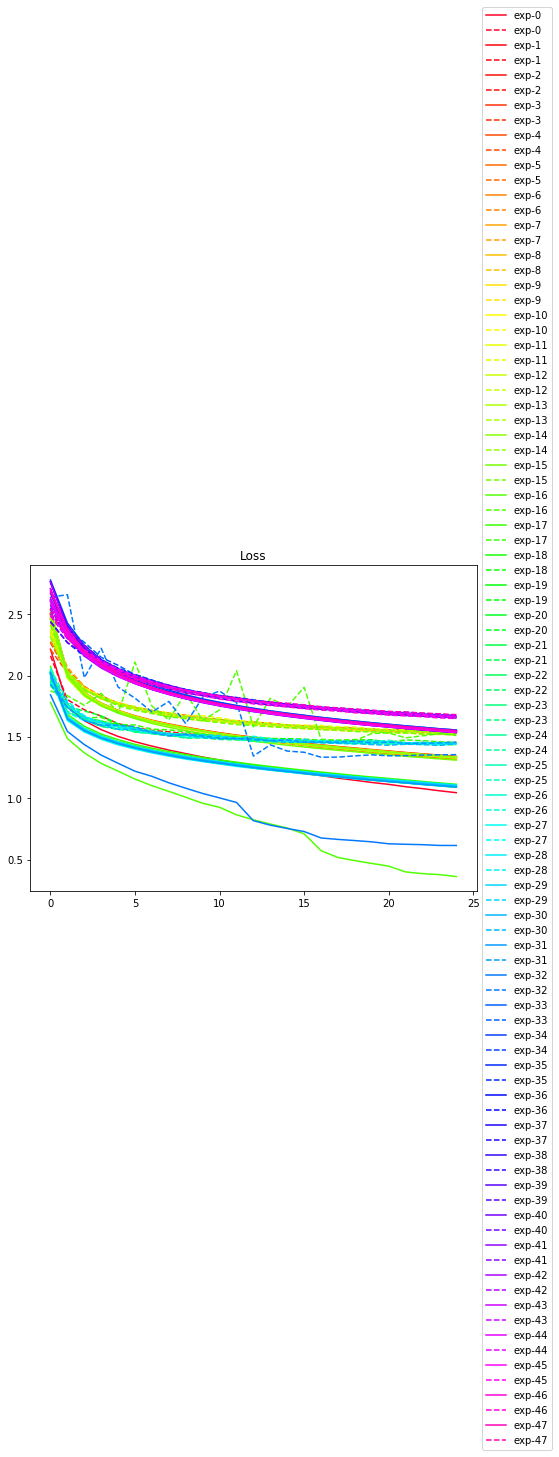

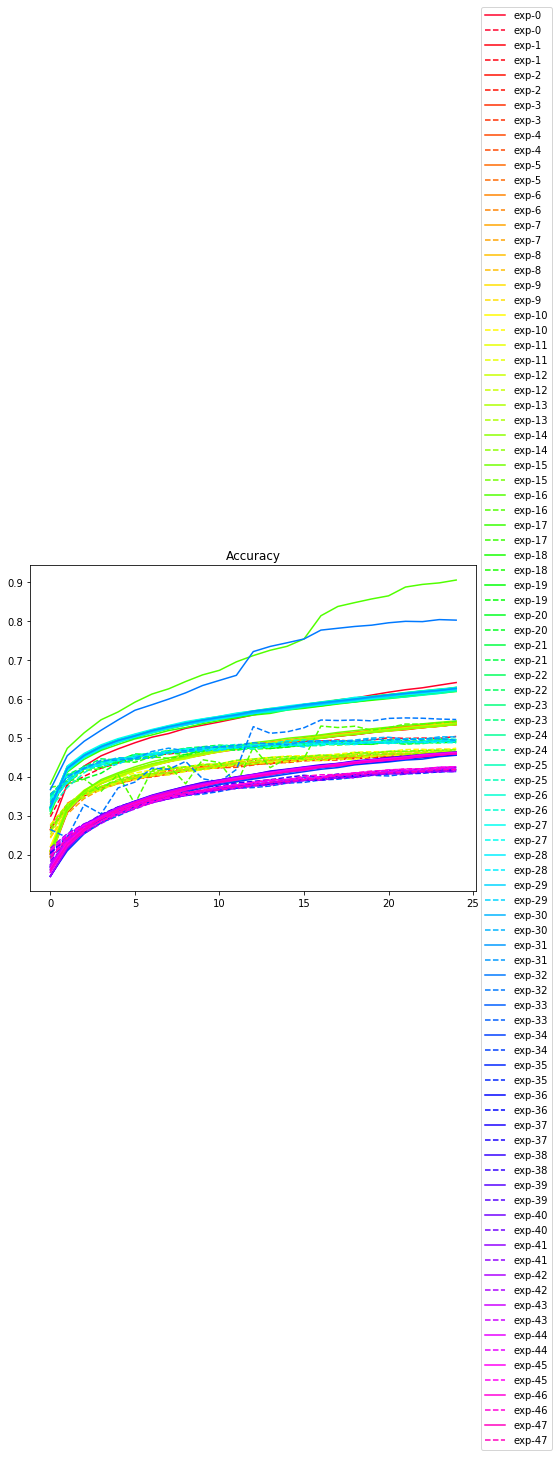

In [9]:
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
%matplotlib inline
NUM_COLORS = len(results.keys())

cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

In [10]:
# Numbers of exp: 18, SGD, reduce_factor: 0.30, reduce_patient: 7 這個 Accuracy最高